
# Human Activity Recognition — Comparing Feedforward NN vs RNN vs LSTM vs GRU

Train and compare four neural architectures on a real sequential task — smartphone-based **Human Activity Recognition (HAR)** — and visualize what leaders should look for at every step: data quality, leakage checks, baselines, learning curves, confusion matrices, generalization, model size/latency, and trade-offs.

**Models compared**
- **Feedforward NN (MLP)** on flattened sequences (ignores temporal order).
- **SimpleRNN** (vanilla recurrent layer).
- **LSTM** (handles long-term dependencies via gates).
- **GRU** (gated, often smaller/faster than LSTM).

**Dataset (public):** UCI *Human Activity Recognition Using Smartphones* (UCI HAR). It contains tri-axial accelerometer and gyroscope signals for six activities (Walking, Upstairs, Downstairs, Sitting, Standing, Laying). We will use the **Inertial Signals** windows (length 128) as proper sequences: shape `(samples, time_steps=128, channels=9)`.

> If the dataset cannot be downloaded in your environment, this notebook will **fall back to a synthetic dataset** so you can still run the full workflow.


## Setup

In [ ]:
import os, sys, zipfile, io, urllib.request, shutil, time, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, warnings

# For modeling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# For metrics and plots
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    balanced_accuracy_score, precision_score, recall_score,
    f1_score, cohen_kappa_score, matthews_corrcoef, log_loss
)
from sklearn.model_selection import train_test_split

np.random.seed(7)
tf.random.set_seed(7)
warnings.filterwarnings("ignore")

print("Python:", sys.version.split()[0])
print("TensorFlow:", tf.__version__)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)

Python: 3.13.7
TensorFlow: 2.20.0
NumPy: 2.3.2
Pandas: 2.3.2



## Load the UCI HAR Dataset (with fallbacks)

Try multiple official/mirrored URLs. If download fails (e.g., no internet, firewalls), we generate a **synthetic** dataset with similar shape and class balance so the rest of the notebook still runs.


In [2]:
DATA_DIR = Path("data_uci_har")
HAR_DIR = DATA_DIR / "UCI HAR Dataset"

def try_download_uci_har(dest_dir: Path) -> bool:
    dest_dir.mkdir(parents=True, exist_ok=True)
    # Several known URLs (first is the classic direct file)
    urls = [
        "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip",
        # New UCI site may require manual fetch; this is kept as a reference.
        # If the first link fails, users can download manually from UCI and place here.
        # "https://archive.ics.uci.edu/dataset/240/human%2Bactivity%2Brecognition%2Busing%2Bsmartphones"
    ]
    for url in urls:
        try:
            print("Attempting download:", url)
            with urllib.request.urlopen(url, timeout=60) as resp:
                data = resp.read()
            with zipfile.ZipFile(io.BytesIO(data)) as zf:
                zf.extractall(dest_dir)
            print("Downloaded & extracted to:", dest_dir.resolve())
            return True
        except Exception as e:
            print("Download failed from", url, "->", e)
    print("\nManual option: Download 'UCI HAR Dataset.zip' from the UCI page and unzip into:", dest_dir.resolve())
    return False

def load_inertial_har(base: Path):
    # Load 9 channels (body_acc, body_gyro, total_acc) each with x/y/z; each row has 128 time steps.
    channels = [
        "body_acc_x", "body_acc_y", "body_acc_z",
        "body_gyro_x","body_gyro_y","body_gyro_z",
        "total_acc_x","total_acc_y","total_acc_z"
    ]
    def load_split(split):
        X_list = []
        for ch in channels:
            f = base / split / "Inertial Signals" / f"{ch}_{split}.txt"
            arr = np.loadtxt(f)  # shape (n_samples, 128)
            X_list.append(arr[:, :, None])  # (n, 128, 1)
        X = np.concatenate(X_list, axis=2)  # (n, 128, 9)
        y = np.loadtxt(base / split / f"y_{split}.txt").astype(int)  # labels 1..6
        # Map to 0..5
        y = y - 1
        return X, y

    X_train, y_train = load_split("train")
    X_test,  y_test  = load_split("test")

    # Activity labels per UCI HAR
    activity_map = {
        0: "WALKING",
        1: "WALKING_UPSTAIRS",
        2: "WALKING_DOWNSTAIRS",
        3: "SITTING",
        4: "STANDING",
        5: "LAYING",
    }
    return X_train, y_train, X_test, y_test, activity_map

download_ok = False
if not HAR_DIR.exists():
    download_ok = try_download_uci_har(DATA_DIR)
else:
    download_ok = True

USE_SYNTHETIC = False
if download_ok:
    try:
        X_train, y_train, X_test, y_test, activity_map = load_inertial_har(HAR_DIR)
    except Exception as e:
        print("Failed to load inertial signals, falling back to synthetic. Error:", e)
        USE_SYNTHETIC = True
else:
    USE_SYNTHETIC = True

if USE_SYNTHETIC:
    print("Generating synthetic dataset with similar shape...")
    n_train, n_test = 6000, 2500
    time_steps, channels, n_classes = 128, 9, 6
    def make_synth(n):
        # Class-specific sinusoids + noise to mimic different activities
        X = np.zeros((n, time_steps, channels), dtype=np.float32)
        y = np.random.randint(0, n_classes, size=n)
        t = np.linspace(0, 4*np.pi, time_steps)
        for i in range(n):
            cls = y[i]
            base_freq = (cls + 1) * 0.4
            sig = np.sin(base_freq * t)[None, :].T  # (128,1)
            noise = 0.3 * np.random.randn(time_steps, channels)
            X[i] = sig @ np.ones((1, channels)) + noise
        return X, y
    X_train, y_train = make_synth(n_train)
    X_test,  y_test  = make_synth(n_test)
    activity_map = {i: f"CLASS_{i}" for i in range(6)}

n_classes = len(np.unique(y_train))
time_steps = X_train.shape[1]
channels   = X_train.shape[2]

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Classes:", n_classes, activity_map)

Train shape: (7352, 128, 9)  Test shape: (2947, 128, 9)
Classes: 6 {0: 'WALKING', 1: 'WALKING_UPSTAIRS', 2: 'WALKING_DOWNSTAIRS', 3: 'SITTING', 4: 'STANDING', 5: 'LAYING'}



## Explore data and visualize sequences


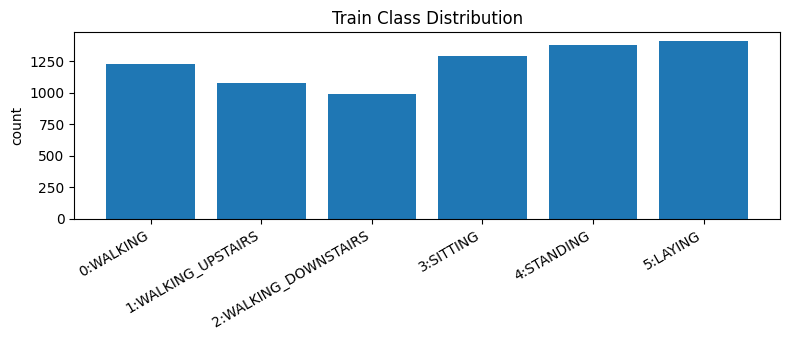

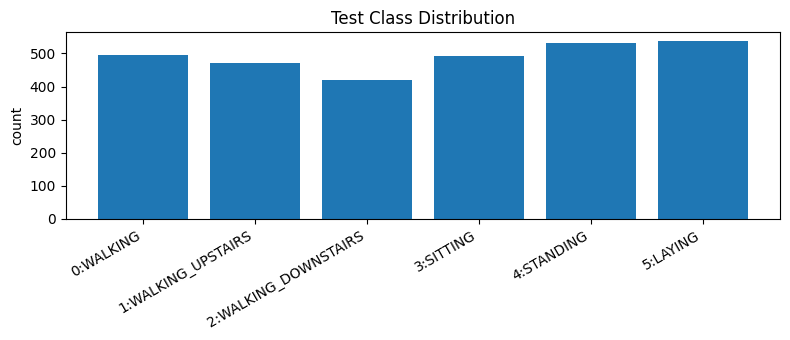

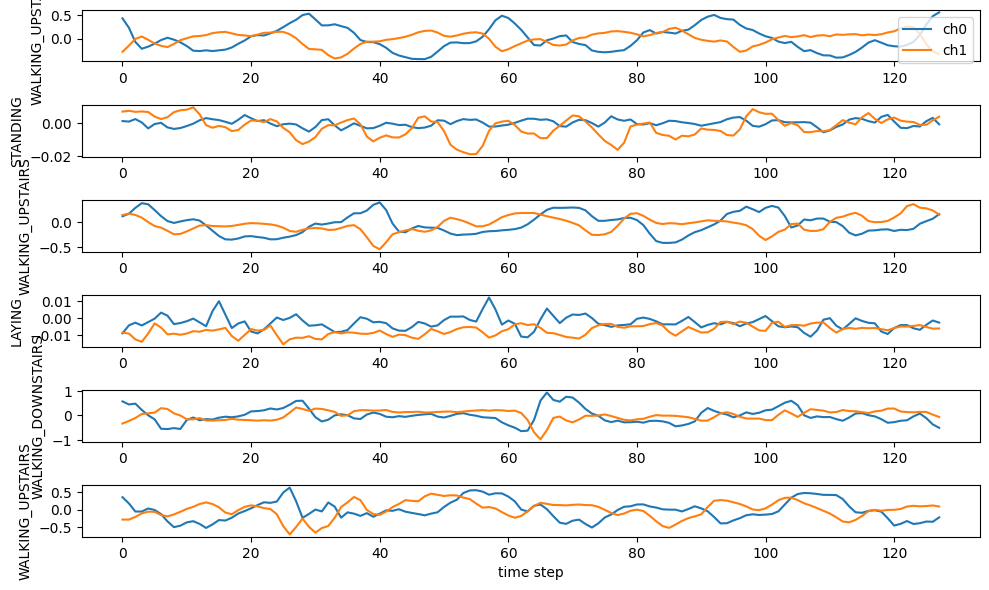

In [3]:
# Class distribution
def plot_class_counts(y, title):
    counts = pd.Series(y).value_counts().sort_index()
    labels = [f"{i}:{activity_map[i]}" for i in counts.index]
    plt.figure(figsize=(8,3.5)); plt.bar(labels, counts.values)
    plt.title(title); plt.ylabel("count"); plt.xticks(rotation=30, ha='right'); plt.tight_layout(); plt.show()

plot_class_counts(y_train, "Train Class Distribution")
plot_class_counts(y_test,  "Test Class Distribution")

# Plot a few example windows (first two channels only for readability)
def plot_example_sequences(X, y, n=6):
    idxs = np.random.choice(len(X), size=n, replace=False)
    plt.figure(figsize=(10, 6))
    for i, idx in enumerate(idxs, 1):
        ax = plt.subplot(n, 1, i)
        ax.plot(X[idx, :, 0], label="ch0")
        ax.plot(X[idx, :, 1], label="ch1")
        ax.set_ylabel(f"{activity_map[int(y[idx])]}")
        if i == 1: ax.legend(loc='upper right')
    plt.xlabel("time step"); plt.tight_layout(); plt.show()

plot_example_sequences(X_train, y_train, n=6)


## Train/Validation split and preprocessing

Keep the dataset’s **pre-defined test set** (different subjects) and split the training set into train/validation. Standardize each channel by the **training** mean/std to avoid leakage.


In [4]:
# Train/Val split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=7)

# Standardize per-channel using training statistics only
mu = X_tr.mean(axis=(0,1), keepdims=True)
sd = X_tr.std(axis=(0,1), keepdims=True) + 1e-8
X_tr  = (X_tr  - mu) / sd
X_val = (X_val - mu) / sd
X_te  = (X_test - mu) / sd

print("Standardized shapes:", X_tr.shape, X_val.shape, X_te.shape)

Standardized shapes: (5881, 128, 9) (1471, 128, 9) (2947, 128, 9)



## Baselines

- **Majority class** accuracy
- **Feedforward NN (MLP)** on flattened sequences (order-less baseline)


In [5]:
# Majority baseline
majority_class = pd.Series(y_tr).mode()[0]
maj_acc = np.mean(y_test == majority_class)
print("Majority-class baseline accuracy (on Test):", round(float(maj_acc), 4))

# Prepare one-hot labels for Keras
def to_onehot(y, n_classes):
    Y = np.zeros((len(y), n_classes), dtype=np.float32)
    Y[np.arange(len(y)), y] = 1.0
    return Y

Y_tr, Y_val, Y_te = to_onehot(y_tr, n_classes), to_onehot(y_val, n_classes), to_onehot(y_test, n_classes)

# Flattened inputs for MLP
X_tr_flat = X_tr.reshape((X_tr.shape[0], -1))
X_val_flat = X_val.reshape((X_val.shape[0], -1))
X_te_flat  = X_te.reshape((X_te.shape[0],  -1))

def build_mlp(input_dim, n_classes):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(n_classes, activation="softmax")
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

mlp = build_mlp(X_tr_flat.shape[1], n_classes)
mlp.summary()

cb = [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy")]
hist_mlp = mlp.fit(X_tr_flat, Y_tr, validation_data=(X_val_flat, Y_val),
                   epochs=30, batch_size=128, verbose=2, callbacks=cb)
mlp_test_loss, mlp_test_acc = mlp.evaluate(X_te_flat, Y_te, verbose=0)
print("MLP Test Acc:", round(float(mlp_test_acc), 4))

Majority-class baseline accuracy (on Test): 0.1822


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,230 (610.27 KB)

 Trainable params: 156,230 (610.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
46/46 - 1s - 11ms/step - accuracy: 0.6198 - loss: 1.0479 - val_accuracy: 0.8586 - val_loss: 0.4789
Epoch 2/30
46/46 - 0s - 2ms/step - accuracy: 0.8172 - loss: 0.5206 - val_accuracy: 0.8946 - val_loss: 0.3009
Epoch 3/30
46/46 - 0s - 2ms/step - accuracy: 0.8747 - loss: 0.3684 - val_accuracy: 0.9109 - val_loss: 0.2514
Epoch 4/30
46/46 - 0s - 2ms/step - accuracy: 0.8975 - loss: 0.2847 - val_accuracy: 0.9273 - val_loss: 0.2083
Epoch 5/30
46/46 - 0s - 2ms/step - accuracy: 0.9085 - loss: 0.2479 - val_accuracy: 0.9307 - val_loss: 0.1794
Epoch 6/30
46/46 - 0s - 2ms/step - accuracy: 0.9150 - loss: 0.2239 - val_accuracy: 0.9293 - val_loss: 0.1832
Epoch 7/30
46/46 - 0s - 2ms/step - accuracy: 0.9281 - loss: 0.1964 - val_accuracy: 0.9381 - val_loss: 0.1657
Epoch 8/30
46/46 - 0s - 2ms/step - accuracy: 0.9323 - loss: 0.1851 - val_accuracy: 0.9341 - val_loss: 0.1610
Epoch 9/30
46/46 - 0s - 2ms/step - accuracy: 0.9367 - loss: 0.1666 - val_accuracy: 0.9341 - val_loss: 0.1587
Epoch 10/30
46/46 


## Recurrent models: SimpleRNN, LSTM, GRU
Train three sequential models with similar capacity and compare.


In [6]:
def build_recurrent(kind:str, time_steps:int, channels:int, n_classes:int, units:int=64):
    model = keras.Sequential([layers.Input(shape=(time_steps, channels))])
    if kind == "rnn":
        model.add(layers.SimpleRNN(units, return_sequences=False))
    elif kind == "lstm":
        model.add(layers.LSTM(units, return_sequences=False))
    elif kind == "gru":
        model.add(layers.GRU(units, return_sequences=False))
    else:
        raise ValueError("Unknown kind")
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(n_classes, activation="softmax"))
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

results = []
histories = {}

for kind in ["rnn", "lstm", "gru"]:
    print("\nTraining", kind.upper(), "…")
    model = build_recurrent(kind, time_steps, channels, n_classes, units=64)
    model.summary()
    cb = [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy")]
    hist = model.fit(X_tr, Y_tr, validation_data=(X_val, Y_val),
                     epochs=30, batch_size=128, verbose=2, callbacks=cb)
    test_loss, test_acc = model.evaluate(X_te, Y_te, verbose=0)
    results.append({"model": kind.upper(), "test_acc": float(test_acc), "params": model.count_params()})
    histories[kind] = hist.history

# Add MLP results too
results.append({"model": "MLP", "test_acc": float(mlp_test_acc), "params": mlp.count_params()})
res_df = pd.DataFrame(results).sort_values("test_acc", ascending=False).reset_index(drop=True)
res_df


Training RNN …


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,286 (36.27 KB)

 Trainable params: 9,286 (36.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
46/46 - 1s - 22ms/step - accuracy: 0.4603 - loss: 1.3681 - val_accuracy: 0.6030 - val_loss: 0.9485
Epoch 2/30
46/46 - 0s - 8ms/step - accuracy: 0.6366 - loss: 0.8780 - val_accuracy: 0.7111 - val_loss: 0.7180
Epoch 3/30
46/46 - 0s - 8ms/step - accuracy: 0.6535 - loss: 0.8550 - val_accuracy: 0.6513 - val_loss: 0.8786
Epoch 4/30
46/46 - 0s - 8ms/step - accuracy: 0.6669 - loss: 0.7969 - val_accuracy: 0.6995 - val_loss: 0.6697
Epoch 5/30
46/46 - 0s - 8ms/step - accuracy: 0.7147 - loss: 0.6593 - val_accuracy: 0.7335 - val_loss: 0.5936
Epoch 6/30
46/46 - 0s - 8ms/step - accuracy: 0.7264 - loss: 0.6298 - val_accuracy: 0.7294 - val_loss: 0.6032
Epoch 7/30
46/46 - 0s - 8ms/step - accuracy: 0.7453 - loss: 0.5715 - val_accuracy: 0.7723 - val_loss: 0.5352
Epoch 8/30
46/46 - 0s - 8ms/step - accuracy: 0.7703 - loss: 0.5354 - val_accuracy: 0.7967 - val_loss: 0.5133
Epoch 9/30
46/46 - 0s - 8ms/step - accuracy: 0.7881 - loss: 0.4991 - val_accuracy: 0.8103 - val_loss: 0.4923
Epoch 10/30
46/46 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,494 (91.77 KB)

 Trainable params: 23,494 (91.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
46/46 - 2s - 51ms/step - accuracy: 0.5372 - loss: 1.3222 - val_accuracy: 0.6173 - val_loss: 0.9306
Epoch 2/30
46/46 - 2s - 35ms/step - accuracy: 0.7194 - loss: 0.6895 - val_accuracy: 0.7845 - val_loss: 0.6014
Epoch 3/30
46/46 - 2s - 33ms/step - accuracy: 0.8298 - loss: 0.4532 - val_accuracy: 0.8872 - val_loss: 0.3362
Epoch 4/30
46/46 - 2s - 38ms/step - accuracy: 0.9095 - loss: 0.2632 - val_accuracy: 0.9245 - val_loss: 0.2429
Epoch 5/30
46/46 - 2s - 42ms/step - accuracy: 0.9340 - loss: 0.2008 - val_accuracy: 0.9381 - val_loss: 0.1624
Epoch 6/30
46/46 - 2s - 38ms/step - accuracy: 0.9481 - loss: 0.1609 - val_accuracy: 0.9388 - val_loss: 0.1809
Epoch 7/30
46/46 - 2s - 36ms/step - accuracy: 0.9379 - loss: 0.1800 - val_accuracy: 0.9279 - val_loss: 0.2017
Epoch 8/30
46/46 - 2s - 36ms/step - accuracy: 0.9503 - loss: 0.1455 - val_accuracy: 0.9429 - val_loss: 0.1653
Epoch 9/30
46/46 - 2s - 37ms/step - accuracy: 0.9497 - loss: 0.1356 - val_accuracy: 0.9347 - val_loss: 0.1875
Epoch 10/3

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,950 (74.02 KB)

 Trainable params: 18,950 (74.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
46/46 - 2s - 51ms/step - accuracy: 0.4396 - loss: 1.4026 - val_accuracy: 0.7056 - val_loss: 1.0604
Epoch 2/30
46/46 - 2s - 33ms/step - accuracy: 0.7094 - loss: 0.8804 - val_accuracy: 0.7729 - val_loss: 0.6920
Epoch 3/30
46/46 - 2s - 34ms/step - accuracy: 0.8072 - loss: 0.5409 - val_accuracy: 0.8688 - val_loss: 0.4009
Epoch 4/30
46/46 - 2s - 35ms/step - accuracy: 0.8922 - loss: 0.3048 - val_accuracy: 0.9164 - val_loss: 0.2482
Epoch 5/30
46/46 - 2s - 33ms/step - accuracy: 0.9371 - loss: 0.1822 - val_accuracy: 0.9368 - val_loss: 0.1743
Epoch 6/30
46/46 - 2s - 33ms/step - accuracy: 0.9486 - loss: 0.1469 - val_accuracy: 0.9388 - val_loss: 0.1669
Epoch 7/30
46/46 - 2s - 36ms/step - accuracy: 0.9503 - loss: 0.1387 - val_accuracy: 0.9381 - val_loss: 0.1631
Epoch 8/30
46/46 - 2s - 33ms/step - accuracy: 0.9492 - loss: 0.1331 - val_accuracy: 0.9402 - val_loss: 0.1530
Epoch 9/30
46/46 - 2s - 37ms/step - accuracy: 0.9514 - loss: 0.1285 - val_accuracy: 0.9449 - val_loss: 0.1512
Epoch 10/3

,model,test_acc,params
0,GRU,0.909060,18950
1,LSTM,0.908042,23494
2,MLP,0.905327,156230
3,RNN,0.755684,9286



## Learning curves & capacity vs. accuracy


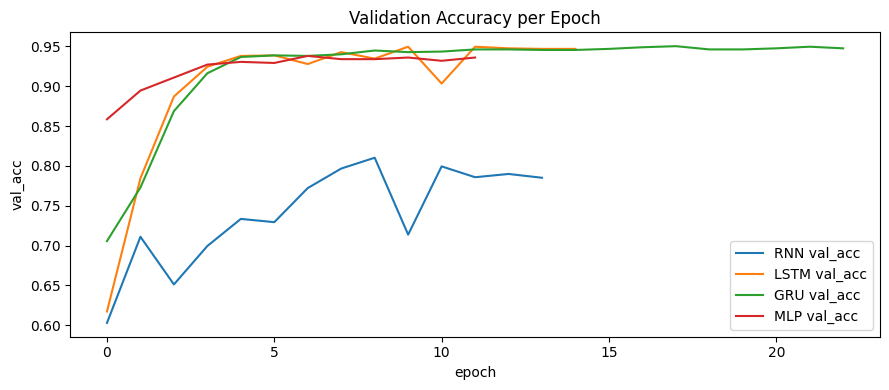

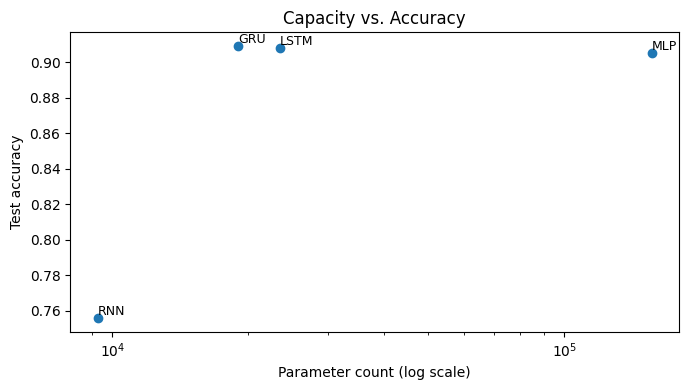

In [7]:
def plot_learning_curves(hist_dict, title):
    plt.figure(figsize=(9,4))
    for name, hist in hist_dict.items():
        plt.plot(hist["val_accuracy"], label=f"{name.upper()} val_acc")
    plt.title(title); plt.xlabel("epoch"); plt.ylabel("val_acc"); plt.legend(); plt.tight_layout(); plt.show()

# Histories include only RNN/LSTM/GRU; fetch MLP from its Keras History object
hist_dict = histories.copy()
hist_dict["mlp"] = {"val_accuracy": [float(x) for x in (globals().get("hist_mlp").history.get("val_accuracy", []))]}
plot_learning_curves(hist_dict, "Validation Accuracy per Epoch")

# Params vs accuracy
plt.figure(figsize=(7,4))
plt.scatter(res_df["params"], res_df["test_acc"])
for i, r in res_df.iterrows():
    plt.text(r["params"], r["test_acc"], r["model"], fontsize=9, ha="left", va="bottom")
plt.xscale("log")
plt.xlabel("Parameter count (log scale)")
plt.ylabel("Test accuracy")
plt.title("Capacity vs. Accuracy")
plt.tight_layout(); plt.show()


## Confusion matrices & per-class metrics

Compute predictions from the best-performing model and visualize the confusion matrix and class-wise precision/recall/F1.


Best model: GRU
                    precision    recall  f1-score   support

           WALKING       0.95      0.95      0.95       496
  WALKING_UPSTAIRS       0.89      0.92      0.90       471
WALKING_DOWNSTAIRS       0.89      0.97      0.93       420
           SITTING       0.81      0.80      0.80       491
          STANDING       0.86      0.82      0.84       532
            LAYING       1.00      0.95      0.97       537

          accuracy                           0.90      2947
         macro avg       0.90      0.90      0.90      2947
      weighted avg       0.90      0.90      0.90      2947



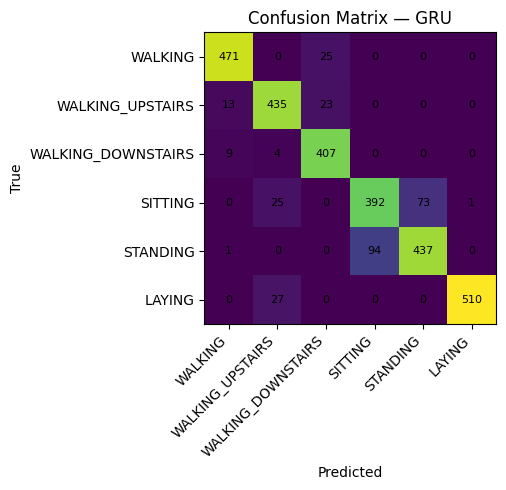

In [8]:
# Choose the best model by test_acc
best_name = res_df.iloc[0]["model"]
print("Best model:", best_name)

def get_model_by_name(name):
    if name == "MLP":
        return mlp, lambda X: X.reshape((X.shape[0], -1))
    k = name.lower()
    # Rebuild and re-train is wasteful; instead, we kept the last trained instances in memory.
    # We'll re-train quickly to obtain the trained instance when needed (simple approach for clarity).
    model = build_recurrent(k, time_steps, channels, n_classes, units=64)
    cb = [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy")]
    _ = model.fit(X_tr, Y_tr, validation_data=(X_val, Y_val), epochs=30, batch_size=128, verbose=0, callbacks=cb)
    if k in ("rnn","lstm","gru"):
        return model, lambda X: X
    raise ValueError("Unknown model name")

best_model, X_mapper = get_model_by_name(best_name)
Xte_in = X_mapper(X_te)
Y_pred = best_model.predict(Xte_in, batch_size=256, verbose=0)
y_pred = Y_pred.argmax(axis=1)

print(classification_report(y_test, y_pred, target_names=[activity_map[i] for i in range(n_classes)]))

cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title(f"Confusion Matrix — {best_name}")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_xticks(range(n_classes)); ax.set_yticks(range(n_classes))
ax.set_xticklabels([activity_map[i] for i in range(n_classes)], rotation=45, ha='right')
ax.set_yticklabels([activity_map[i] for i in range(n_classes)])
for i in range(n_classes):
    for j in range(n_classes):
        ax.text(j, i, cm[i, j], ha="center", va="center", fontsize=8)
plt.tight_layout(); plt.show()

## Metrics beyond accuracy: Show they tell a consistent story

Scoring MLP …
Scoring RNN …
Scoring LSTM …
Scoring GRU …


,accuracy,balanced_accuracy,precision_macro,precision_weighted,recall_macro,recall_weighted,f1_macro,f1_weighted,cohen_kappa,mcc,log_loss,params
model,,,,,,,,,,,,
GRU,0.910417,0.910417,0.909352,0.909219,0.910417,0.910417,0.909745,0.909678,0.892360,0.892417,0.329833,18950
MLP,0.905327,0.906254,0.904393,0.906144,0.906254,0.905327,0.904700,0.905169,0.886309,0.886517,0.328138,156230
LSTM,0.892094,0.894325,0.892752,0.893359,0.894325,0.892094,0.892963,0.892173,0.870422,0.870628,0.381443,23494
RNN,0.851374,0.848598,0.851493,0.853209,0.848598,0.851374,0.849377,0.851620,0.821375,0.821644,0.443275,9286



Metric correlation matrix (excluding params & log_loss):


,accuracy,balanced_accuracy,precision_macro,precision_weighted,recall_macro,recall_weighted,f1_macro,f1_weighted,cohen_kappa,mcc
accuracy,1.000000,0.998736,0.999673,0.999430,0.998736,1.000000,0.999403,0.999948,0.999999,0.999995
balanced_accuracy,0.998736,1.000000,0.999623,0.999492,1.000000,0.998736,0.999807,0.999123,0.998800,0.998854
precision_macro,0.999673,0.999623,1.000000,0.999561,0.999623,0.999673,0.999958,0.999787,0.999699,0.999710
precision_weighted,0.999430,0.999492,0.999561,1.000000,0.999492,0.999430,0.999504,0.999720,0.999473,0.999530
recall_macro,0.998736,1.000000,0.999623,0.999492,1.000000,0.998736,0.999807,0.999123,0.998800,0.998854
recall_weighted,1.000000,0.998736,0.999673,0.999430,0.998736,1.000000,0.999403,0.999948,0.999999,0.999995
f1_macro,0.999403,0.999807,0.999958,0.999504,0.999807,0.999403,1.000000,0.999589,0.999440,0.999460
f1_weighted,0.999948,0.999123,0.999787,0.999720,0.999123,0.999948,0.999589,1.000000,0.999961,0.999975
cohen_kappa,0.999999,0.998800,0.999699,0.999473,0.998800,0.999999,0.999440,0.999961,1.000000,0.999998
mcc,0.999995,0.998854,0.999710,0.999530,0.998854,0.999995,0.999460,0.999975,0.999998,1.000000


Note: Accuracy vs Macro-F1 - Models should lie close to diagonal if they tell the same story.


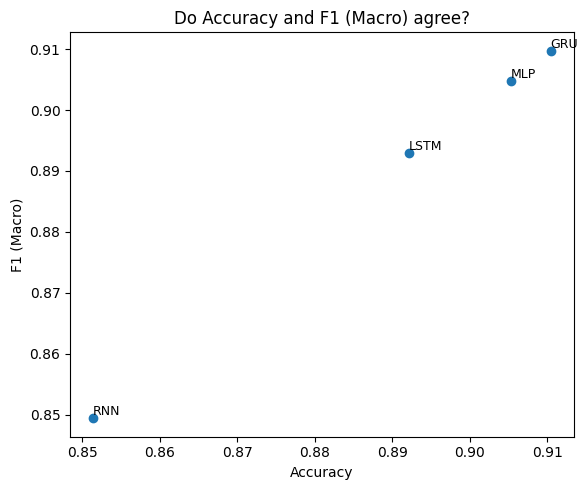

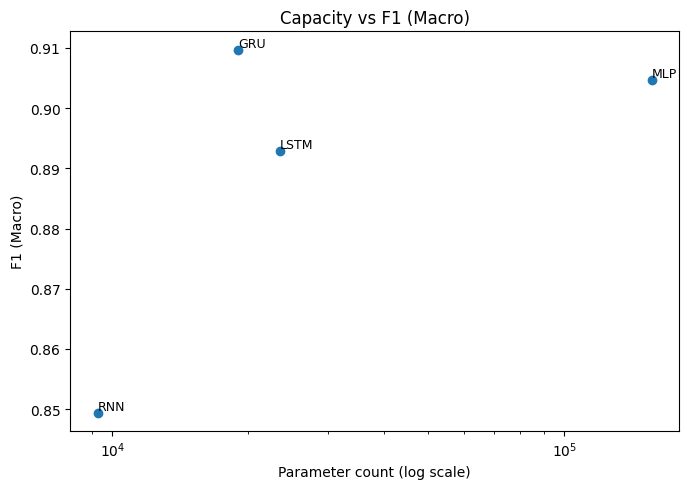


Model ranks across metrics (1 = best). Lower is better:


,accuracy,balanced_accuracy,f1_macro,f1_weighted,precision_macro,recall_macro,cohen_kappa,mcc
model,,,,,,,,
GRU,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
MLP,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
LSTM,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
RNN,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0



If ranks are similar across columns, different metrics are not telling a different story here.


In [15]:
# Get a trained model instance by name (retrain quickly to ensure availability)
def _get_model_by_name(name:str):
    global mlp  # from earlier section
    if name.upper() == "MLP":
        # uses flattened inputs
        def mapper(X): return X.reshape((X.shape[0], -1))
        return mlp, mapper, False
    # recurrent models use (time, channels)
    k = name.lower()
    model = build_recurrent(k, time_steps, channels, n_classes, units=64)
    cb = [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy")]
    _ = model.fit(X_tr, Y_tr, validation_data=(X_val, Y_val),
                  epochs=30, batch_size=128, verbose=0, callbacks=cb)
    return model, (lambda X: X), True

def evaluate_model(model, X, y_true):
    """Return a dict of metrics using predicted probabilities (for log_loss) and labels."""
    # Probabilities and labels
    prob = model.predict(X, batch_size=256, verbose=0)
    y_pred = prob.argmax(axis=1)

    # Metrics
    out = {
        "accuracy": accuracy_score(y_true, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        "precision_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "precision_weighted": precision_score(y_true, y_pred, average="weighted", zero_division=0),
        "recall_macro": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "recall_weighted": recall_score(y_true, y_pred, average="weighted", zero_division=0),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
        "f1_weighted": f1_score(y_true, y_pred, average="weighted"),
        "cohen_kappa": cohen_kappa_score(y_true, y_pred),
        "mcc": matthews_corrcoef(y_true, y_pred),
        "log_loss": log_loss(y_true, prob)
    }
    return out

model_names = ["MLP", "RNN", "LSTM", "GRU"]
rows = []

for name in model_names:
    print(f"Scoring {name} …")
    model, mapper, retrained = _get_model_by_name(name)
    Xte_in = mapper(X_te)
    metrics = evaluate_model(model, Xte_in, y_test)
    metrics["model"] = name
    metrics["params"] = model.count_params()
    rows.append(metrics)

metrics_df = pd.DataFrame(rows).set_index("model")
# Sort by macro-F1 (safer under imbalance) to emphasize consistency with accuracy
metrics_df = metrics_df.sort_values("f1_macro", ascending=False)
display(metrics_df)

# Correlation matrix to show the metrics largely agree (high positive correlations)
corr = metrics_df.drop(columns=["params", "log_loss"]).corr()
print("\nMetric correlation matrix (excluding params & log_loss):")
display(corr)

# Plot: Accuracy vs Macro-F1
print("Note: Accuracy vs Macro-F1 - Models should lie close to diagonal if they tell the same story.")
plt.figure(figsize=(6,5))
plt.scatter(metrics_df["accuracy"], metrics_df["f1_macro"])
for m, r in metrics_df.iterrows():
    plt.text(r["accuracy"], r["f1_macro"], m, fontsize=9, ha="left", va="bottom")
plt.xlabel("Accuracy")
plt.ylabel("F1 (Macro)")
plt.title("Do Accuracy and F1 (Macro) agree?")
plt.tight_layout(); plt.show()

# Capacity vs multiple metrics: overlay text for quick scan (optional)
plt.figure(figsize=(7,5))
plt.scatter(metrics_df["params"], metrics_df["f1_macro"])
for m, r in metrics_df.iterrows():
    plt.text(r["params"], r["f1_macro"], f"{m}", fontsize=9, ha="left", va="bottom")
plt.xscale("log")
plt.xlabel("Parameter count (log scale)")
plt.ylabel("F1 (Macro)")
plt.title("Capacity vs F1 (Macro)")
plt.tight_layout(); plt.show()

# Quick narrative check
rank_cols = ["accuracy","balanced_accuracy","f1_macro","f1_weighted","precision_macro","recall_macro","cohen_kappa","mcc"]
ranks = metrics_df[rank_cols].rank(ascending=False, method="min")
print("\nModel ranks across metrics (1 = best). Lower is better:")
display(ranks)
print("\nIf ranks are similar across columns, different metrics are not telling a different story here.")


## Practicality: latency & throughput (inference micro-benchmark)


In [9]:
def benchmark_inference(model, X, batch_sizes=[1, 32, 128, 512]):
    times = []
    for b in batch_sizes:
        # Warmup
        _ = model.predict(X[:b], verbose=0)
        t0 = time.time()
        _ = model.predict(X[:b], verbose=0)
        t1 = time.time()
        times.append({"batch": b, "ms_per_batch": (t1 - t0)*1000.0})
    return pd.DataFrame(times)

lat_df = benchmark_inference(best_model, Xte_in)
lat_df

,batch,ms_per_batch
0,1,23.504972
1,32,23.547173
2,128,33.216953
3,512,74.470758


## References
- UCI Machine Learning Repository — *Human Activity Recognition Using Smartphones* (HAR).  
  https://archive.ics.uci.edu/dataset/240/human%2Bactivity%2Brecognition%2Busing%2Bsmartphones